In [2]:
import sys
print(sys.executable)

c:\Users\ASUS\AppData\Local\Programs\Python\Python311\python.exe


In [3]:
%pip install plotly

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import plotly.express as px
import os

In [26]:
df1 = pd.read_csv('DATASET PT. KREASI PUTRA HOTAMA 2025 - Data.csv')  # File dengan Customer_id
df2 = pd.read_csv('DATASET PT. KREASI PUTRA HOTAMA 2025 - Data2.csv')  # File dengan Customer_name

df1.columns = df1.columns.str.strip()
df2.columns = df2.columns.str.strip()

df1['Order_date'] = pd.to_datetime(df1['Order_date'])
df2['Order_date'] = pd.to_datetime(df2['Order_date'])


merged_df = pd.merge(
    df2, df1,
    on=['Order_id', 'Product_code', 'Product_Name', 'Quantity', 'Order_date', 'Price'],
    how='inner'
)

final_df = merged_df[['Customer_name', 'Customer_id', 'Order_id', 'Product_code', 'Product_Name', 'Quantity', 'Order_date', 'Price']]
final_df['Customer_id'] = final_df['Customer_id'].astype(int).astype(str)
final_df['Customer_name'] = final_df['Customer_name'].astype(str).str.strip()

In [6]:
# %% [3] Bersihkan dan hitung Total_Transaksi
df = final_df.copy()
df['Price_clean'] = df['Price'].astype(str) \
    .str.replace('Rp', '', regex=False) \
    .str.replace('.', '', regex=False) \
    .str.replace(',', '.', regex=False) \
    .str.strip()
df['Price_clean'] = pd.to_numeric(df['Price_clean'], errors='coerce')

df['Order_id'] = df['Order_id'].fillna(method='ffill')

df_clean = df.dropna(subset=['Customer_id', 'Order_date', 'Price_clean']).copy()

df_clean['Total_Transaksi'] = df_clean['Quantity'] * df_clean['Price_clean']

df_clean = df_clean[df_clean['Total_Transaksi'] > 0]

C:\Users\ASUS\AppData\Local\Temp\ipykernel_29300\4124420428.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Order_id'] = df['Order_id'].fillna(method='ffill')


In [7]:
df_clean.info()
df_clean.describe()
len(df_clean)

<class 'pandas.core.frame.DataFrame'>
Index: 2046 entries, 1 to 14554
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Customer_name    2046 non-null   object        
 1   Customer_id      2046 non-null   object        
 2   Order_id         2046 non-null   object        
 3   Product_code     2046 non-null   int64         
 4   Product_Name     2046 non-null   object        
 5   Quantity         2046 non-null   int64         
 6   Order_date       2046 non-null   datetime64[ns]
 7   Price            2046 non-null   object        
 8   Price_clean      2046 non-null   int64         
 9   Total_Transaksi  2046 non-null   int64         
dtypes: datetime64[ns](1), int64(4), object(5)
memory usage: 175.8+ KB


2046

In [8]:
# Hitung jumlah data sebelum dan sesudah dibersihkan
jumlah_awal = len(df)
jumlah_bersih = len(df_clean)

print(f"Jumlah data sebelum dibersihkan: {jumlah_awal}")
print(f"Jumlah data setelah dibersihkan: {jumlah_bersih}")

Jumlah data sebelum dibersihkan: 14557
Jumlah data setelah dibersihkan: 2046


In [9]:
# %% [4] Hitung RFM dan agregasi
ref_date = df_clean['Order_date'].max()
df_agg = df_clean.groupby('Customer_id').agg({
    'Order_id': 'count',
    'Total_Transaksi': 'sum',
    'Order_date': 'max'
}).reset_index()
df_agg.rename(columns={'Order_id': 'Frequency', 'Order_date': 'Last_Order_Date'}, inplace=True)
df_agg['Recency'] = (ref_date - df_agg['Last_Order_Date']).dt.days
df_agg['Avg_Transaction'] = (df_agg['Total_Transaksi'] / df_agg['Frequency']).fillna(0).round(0).astype(int)

In [10]:
# %% [5] Standarisasi dan Clustering KMeans (k=4)
features = df_agg[['Frequency', 'Total_Transaksi', 'Recency', 'Avg_Transaction']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
df_agg['Cluster'] = kmeans.fit_predict(X_scaled)
centroids = scaler.inverse_transform(kmeans.cluster_centers_)

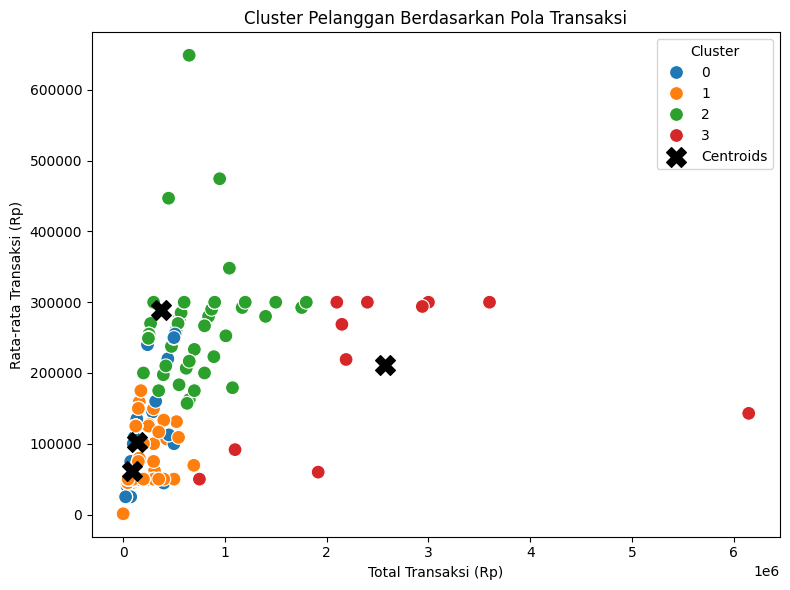

In [11]:
# %% [6] Visualisasi clustering
os.makedirs("assets", exist_ok=True)
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_agg,
    x='Total_Transaksi',
    y='Avg_Transaction',
    hue='Cluster',
    palette='tab10',
    s=100
)
plt.scatter(
    centroids[:, 1], centroids[:, 3],
    marker='X', s=200, color='black', label='Centroids'
)
plt.title('Cluster Pelanggan Berdasarkan Pola Transaksi')
plt.xlabel('Total Transaksi (Rp)')
plt.ylabel('Rata-rata Transaksi (Rp)')
plt.legend(title='Cluster')
plt.tight_layout()
plt.savefig("assets/cluster_transaks2.webp", format='webp')
plt.show()


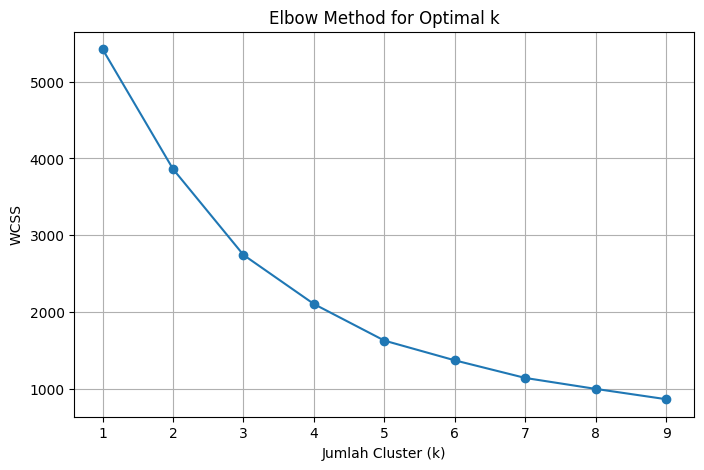

In [12]:
# %% [7] Evaluasi: Elbow Method
wcss = []
range_k = range(1, 10)
for k in range_k:
    model = KMeans(n_clusters=k, random_state=42, n_init=10)
    model.fit(X_scaled)
    wcss.append(model.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range_k, wcss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Jumlah Cluster (k)')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()


In [13]:
# %% [8] Evaluasi DBI & Silhouette
results_dbi, results_sil = [], []
for k in range(2, 6):
    model = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = model.fit_predict(X_scaled)
    results_dbi.append([k, davies_bouldin_score(X_scaled, labels)])
    results_sil.append([k, silhouette_score(X_scaled, labels)])

df_dbi = pd.DataFrame(results_dbi, columns=['Jumlah Cluster', 'Davies-Bouldin Index'])
df_sil = pd.DataFrame(results_sil, columns=['Jumlah Cluster', 'Silhouette Score'])

df_dbi, df_sil

(   Jumlah Cluster  Davies-Bouldin Index
 0               2              1.076581
 1               3              0.886720
 2               4              0.791381
 3               5              0.759713,
    Jumlah Cluster  Silhouette Score
 0               2          0.439248
 1               3          0.451525
 2               4          0.471601
 3               5          0.480969)

In [15]:
# %% [9] Gabungkan hasil clustering ke data transaksi bersih
df_final = df_clean.merge(df_agg[['Customer_id', 'Cluster']], on='Customer_id', how='left')

In [16]:
# %% [10] Buat tabel rekomendasi produk berdasarkan cluster
df_rekomendasi = (
    df_final
    .groupby(['Cluster', 'Product_Name'])['Total_Transaksi']
    .sum()
    .reset_index()
    .sort_values(['Cluster', 'Total_Transaksi'], ascending=[True, False])
)
top_produk = df_rekomendasi.groupby('Cluster').head(1).reset_index(drop=True)

In [17]:
# %% [11] Tampilkan daftar pelanggan bernilai tinggi
# Anggap Cluster 2 dan 3 adalah pelanggan bernilai tinggi (berdasarkan transaksi)
cluster_high_value = [2, 3]
df_high_value = df_agg[df_agg['Cluster'].isin(cluster_high_value)].copy()
df_merged = df_clean.merge(df_high_value[['Customer_id', 'Cluster']], on='Customer_id', how='inner')

# Ambil transaksi terakhir setiap pelanggan
df_latest_orders = (
    df_merged
    .sort_values('Order_date')
    .groupby('Customer_id')
    .tail(1)
)

df_sales_list = df_latest_orders[['Customer_name', 'Customer_id', 'Cluster', 'Order_date', 'Total_Transaksi']].copy()
df_sales_list['Order_date'] = df_sales_list['Order_date'].dt.strftime('%d %B %Y')
df_sales_list['Total_Transaksi'] = df_sales_list['Total_Transaksi'].apply(lambda x: f"Rp {x:,.0f}")

C:\Users\ASUS\AppData\Local\Temp\ipykernel_29300\1164428532.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_agg[df_agg['Cluster'].isin(cluster_high_value)], x='Cluster', palette='viridis')


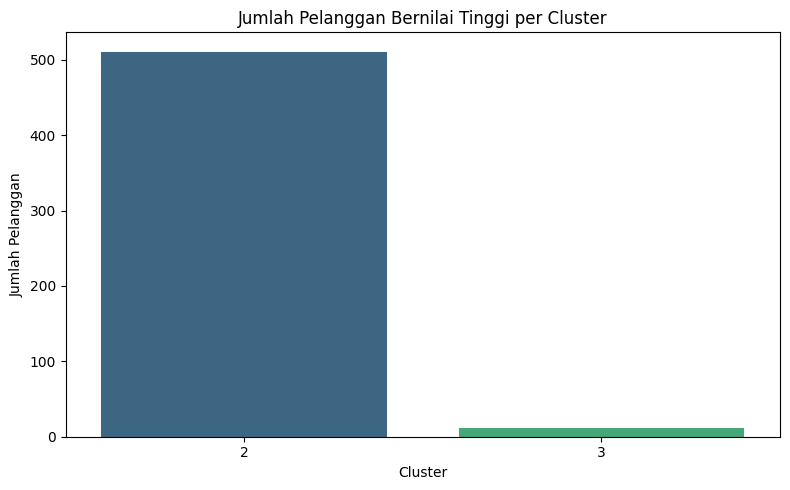

In [18]:
# %% [12] Visualisasi jumlah pelanggan per cluster bernilai tinggi
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.countplot(data=df_agg[df_agg['Cluster'].isin(cluster_high_value)], x='Cluster', palette='viridis')
plt.title('Jumlah Pelanggan Bernilai Tinggi per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Jumlah Pelanggan')
plt.tight_layout()
plt.show()


C:\Users\ASUS\AppData\Local\Temp\ipykernel_29300\3746009543.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
C:\Users\ASUS\AppData\Local\Temp\ipykernel_29300\3746009543.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


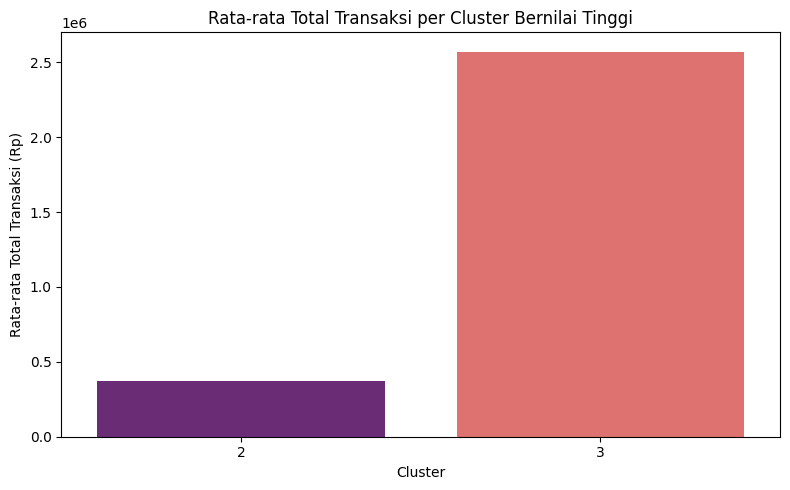

In [19]:
# %% [13] Visualisasi rata-rata transaksi per cluster bernilai tinggi
plt.figure(figsize=(8, 5))
sns.barplot(
    data=df_agg[df_agg['Cluster'].isin(cluster_high_value)],
    x='Cluster',
    y='Total_Transaksi',
    estimator='mean',
    ci=None,
    palette='magma'
)
plt.title('Rata-rata Total Transaksi per Cluster Bernilai Tinggi')
plt.xlabel('Cluster')
plt.ylabel('Rata-rata Total Transaksi (Rp)')
plt.tight_layout()
plt.show()

In [20]:
# Buat ulang dataframe RFM untuk ditampilkan
df_rfm = df_agg[['Customer_id', 'Recency', 'Frequency', 'Total_Transaksi', 'Avg_Transaction', 'Cluster']].copy()

# Tambahkan segmentasi berdasarkan aturan sederhana
def segment_customer(row):
    r, f = row['Recency'], row['Frequency']
    if r <= 30 and f >= 10:
        return "01-Champion"
    elif f >= 7:
        return "02-Loyal Customers"
    elif r <= 60 and f >= 3:
        return "03-Potential Loyalists"
    elif r > 90 and f >= 8:
        return "04-Can't Lose Them"
    elif r > 60 and f <= 3:
        return "05-Need Attention"
    elif r <= 30 and f == 1:
        return "06-New Customers"
    elif r <= 90 and f == 1:
        return "07-Promising"
    elif r > 90 and f <= 4:
        return "08-At Risk"
    elif r > 60 and f <= 2:
        return "09-About to Sleep"
    else:
        return "10-Hibernating"

df_rfm['Segment'] = df_rfm.apply(segment_customer, axis=1)


In [21]:
# Statistik deskriptif per segment
rfm_segment_stats = df_rfm.groupby('Segment').agg(
    Jumlah_Pelanggan=('Customer_id', 'nunique'),
    Rata2_Recency=('Recency', 'mean'),
    Rata2_Frequency=('Frequency', 'mean'),
    Rata2_Monetary=('Total_Transaksi', 'mean')
).sort_values(by='Jumlah_Pelanggan', ascending=False).reset_index()

rfm_segment_stats.round(2)

,Segment,Jumlah_Pelanggan,Rata2_Recency,Rata2_Frequency,Rata2_Monetary
0,05-Need Attention,1126,131.83,1.22,192296.09
1,07-Promising,72,46.26,1.00,129625.00
2,06-New Customers,59,12.31,1.00,159864.39
3,10-Hibernating,42,71.83,3.33,488438.10
4,08-At Risk,21,138.76,4.00,527976.19
5,02-Loyal Customers,20,100.45,10.25,1167123.45
6,03-Potential Loyalists,14,29.21,3.71,323214.29
7,01-Champion,2,11.50,27.50,4873350.00


In [22]:
# Hitung distribusi pelanggan per segment
segment_size = df_rfm['Segment'].value_counts().reset_index()
segment_size.columns = ['Segment', 'Jumlah_Pelanggan']
total_customer = segment_size['Jumlah_Pelanggan'].sum()
segment_size['Persentase'] = (segment_size['Jumlah_Pelanggan'] / total_customer * 100).round(1)
segment_size['Label'] = segment_size.apply(
    lambda row: f"{row['Segment']} ({row['Jumlah_Pelanggan']} | {row['Persentase']}%)", axis=1
)

# Buat visualisasi Treemap
fig = px.treemap(
    segment_size,
    path=['Label'],
    values='Jumlah_Pelanggan',
    color='Segment',
    color_discrete_sequence=px.colors.qualitative.Set3,
    title='🗺️ Distribusi Segmentasi Pelanggan Berdasarkan RFM'
)
fig.update_traces(textinfo='label+value+percent entry')
fig.update_layout(margin=dict(t=50, l=25, r=25, b=25))
fig.show()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_29300\2981480438.py:36: UserWarning:

Glyph 127760 (\N{GLOBE WITH MERIDIANS}) missing from font(s) DejaVu Sans.

C:\Users\ASUS\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning:

Glyph 127760 (\N{GLOBE WITH MERIDIANS}) missing from font(s) DejaVu Sans.



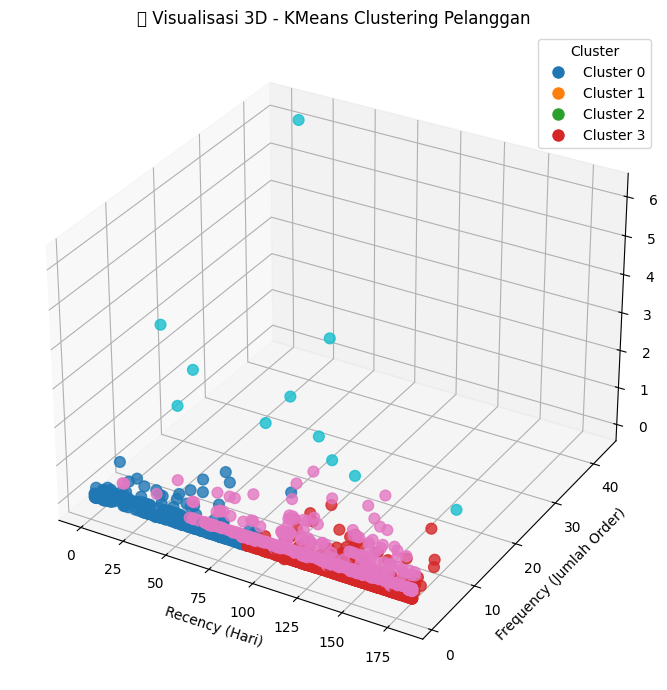

In [23]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# Siapkan data untuk 3D plot
rfm_3d = df_rfm.copy()

# Visualisasi 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot untuk setiap pelanggan
scatter = ax.scatter(
    rfm_3d['Recency'],
    rfm_3d['Frequency'],
    rfm_3d['Total_Transaksi'],
    c=rfm_3d['Cluster'],
    cmap='tab10',
    s=60,
    alpha=0.8
)

# Label sumbu
ax.set_xlabel('Recency (Hari)')
ax.set_ylabel('Frequency (Jumlah Order)')
ax.set_zlabel('Total Transaksi (Rp)')
ax.set_title('🌐 Visualisasi 3D - KMeans Clustering Pelanggan')

# Legenda manual
legend_labels = [f"Cluster {i}" for i in sorted(rfm_3d['Cluster'].unique())]
legend_handles = [plt.Line2D([0], [0], marker='o', color='w',
                             label=label,
                             markerfacecolor=cm.tab10(i / 10), markersize=10)
                  for i, label in enumerate(legend_labels)]
ax.legend(handles=legend_handles, title='Cluster', loc='upper right')

plt.tight_layout()
plt.show()

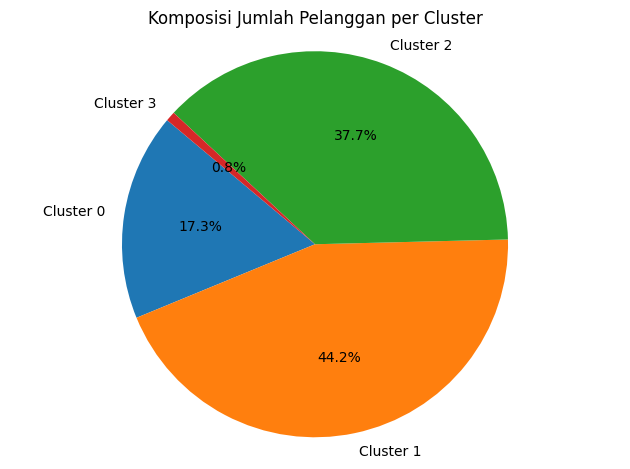

C:\Users\ASUS\AppData\Local\Temp\ipykernel_29300\931538831.py:29: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




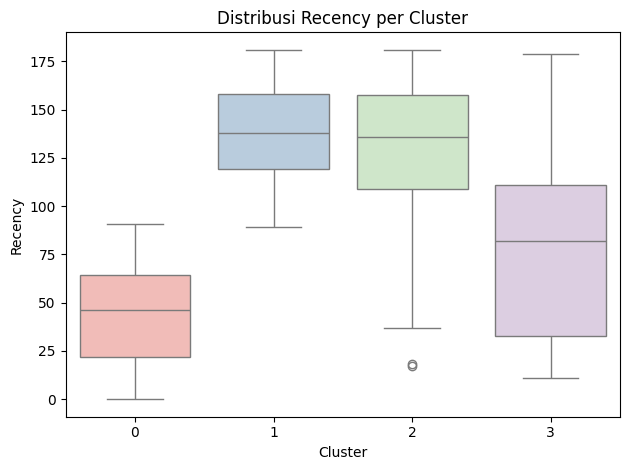

C:\Users\ASUS\AppData\Local\Temp\ipykernel_29300\931538831.py:35: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




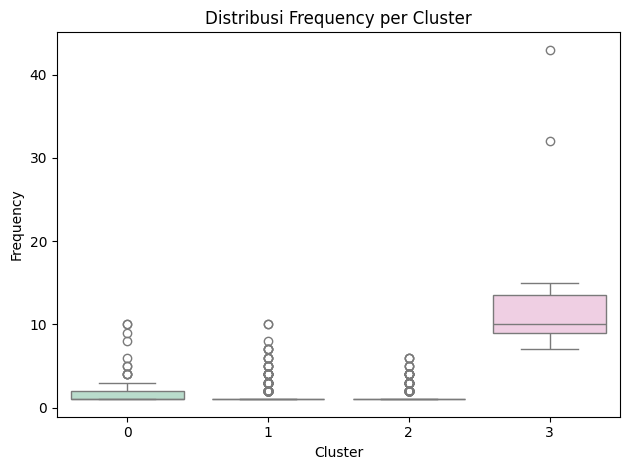

C:\Users\ASUS\AppData\Local\Temp\ipykernel_29300\931538831.py:41: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




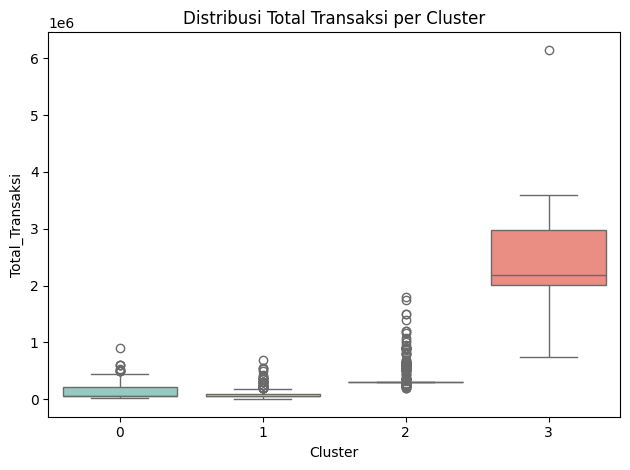

,Cluster,Recency_mean,Recency_median,Recency_nunique,Frequency_mean,Frequency_median,Frequency_nunique,Total_Transaksi_mean,Total_Transaksi_median,Total_Transaksi_nunique
0,0,43.73,46.0,82,1.50,1.0,9,140522.84,50000.0,29
1,1,137.95,138.0,91,1.42,1.0,9,87203.01,50000.0,28
2,2,131.33,136.0,120,1.32,1.0,6,373688.26,300000.0,42
3,3,76.64,82.0,11,15.18,10.0,7,2572209.09,2190800.0,11


In [24]:
# %% [14] Ringkasan statistik per cluster
summary_stats = df_rfm.groupby("Cluster").agg({
    "Recency": ["mean", "median", "nunique"],
    "Frequency": ["mean", "median", "nunique"],
    "Total_Transaksi": ["mean", "median", "nunique"]
}).round(2)
summary_stats.columns = ['_'.join(col) for col in summary_stats.columns]
summary_stats.reset_index(inplace=True)

# %% [15] Pie Chart Komposisi Pelanggan per Cluster
cluster_counts = df_rfm['Cluster'].value_counts().sort_index()
cluster_labels = [f"Cluster {i}" for i in cluster_counts.index]

fig_pie, ax_pie = plt.subplots()
ax_pie.pie(
    cluster_counts,
    labels=cluster_labels,
    autopct='%1.1f%%',
    startangle=140,
    colors=sns.color_palette("tab10")
)
ax_pie.axis("equal")
plt.title("Komposisi Jumlah Pelanggan per Cluster")
plt.tight_layout()
plt.show()

# %% [16] Boxplot Distribusi RFM per Cluster
fig1, ax1 = plt.subplots()
sns.boxplot(data=df_rfm, x="Cluster", y="Recency", palette="Pastel1", ax=ax1)
ax1.set_title("Distribusi Recency per Cluster")
plt.tight_layout()
plt.show()

fig2, ax2 = plt.subplots()
sns.boxplot(data=df_rfm, x="Cluster", y="Frequency", palette="Pastel2", ax=ax2)
ax2.set_title("Distribusi Frequency per Cluster")
plt.tight_layout()
plt.show()

fig3, ax3 = plt.subplots()
sns.boxplot(data=df_rfm, x="Cluster", y="Total_Transaksi", palette="Set3", ax=ax3)
ax3.set_title("Distribusi Total Transaksi per Cluster")
plt.tight_layout()
plt.show()

summary_stats

In [25]:
# Ensure Customer_id is treated as string
df_clean['Customer_id'] = df_clean['Customer_id'].astype(str)
df_rfm['Customer_id'] = df_rfm['Customer_id'].astype(str)

# Segment Function (re-define due to kernel reset)
def segment_customer(row):
    r, f = row['Recency'], row['Frequency']
    if r <= 30 and f >= 10:
        return "01-Champion"
    elif f >= 7:
        return "02-Loyal Customers"
    elif r <= 60 and f >= 3:
        return "03-Potential Loyalists"
    elif r > 90 and f >= 8:
        return "04-Can't Lose Them"
    elif r > 60 and f <= 3:
        return "05-Need Attention"
    elif r <= 30 and f == 1:
        return "06-New Customers"
    elif r <= 90 and f == 1:
        return "07-Promising"
    elif r > 90 and f <= 4:
        return "08-At Risk"
    elif r > 60 and f <= 2:
        return "09-About to Sleep"
    else:
        return "10-Hibernating"

# Tambahkan segmentasi
df_rfm['Segment'] = df_rfm.apply(segment_customer, axis=1)

# Gabungkan dengan nama dan produk
df_rfm_full = df_rfm.merge(
    df_clean[['Customer_id', 'Customer_name', 'Product_Name']],
    on='Customer_id',
    how='left'
).drop_duplicates(subset=['Customer_id', 'Segment', 'Product_Name'])

# Pilih kolom relevan
df_customer_cluster_detail = df_rfm_full[[
    'Customer_id', 'Customer_name', 'Segment', 'Product_Name',
    'Recency', 'Frequency', 'Total_Transaksi'
]].sort_values(by='Segment')

print(df_customer_cluster_detail.head(100).to_string(index=False))


Customer_id                Customer_name                Segment                               Product_Name  Recency  Frequency  Total_Transaksi
    1578742              Testing Account            01-Champion                         QuranTutor 1 Month       12         43          6146700
    1578742              Testing Account            01-Champion                  QuranTutor Family 1 Month       12         43          6146700
    1578742              Testing Account            01-Champion                        QuranTutor 6 Months       12         43          6146700
    1578742              Testing Account            01-Champion                          QuranTutor 1 Year       12         43          6146700
     166916                 john herizal            01-Champion                          Qaraa PRO 1 Tahun       11         12          3600000
      67706                   Fifa Hiola     02-Loyal Customers                          Qaraa PRO 1 Tahun      122          7          